# Calcul de la vitesse critique en fonction de $\beta$ et de $\gamma$

Dans ce code on se propose d'étudier l'impact du paramètre de masse: $\beta = \frac{M}{M+m}$ et du paramètre de gravité $\gamma = \frac{g(m+M)L^{3}}{EI}$ sur la vitesse critique $u_{cr}=\sqrt{\frac{M}{EI}}LU_{cr}$   
La vitesse critique est définie comme la vitesse à partir de laquelle apparait le phénomène de flutter, c'est à dire la vitesse à partir de laquelle, pour au moins un mode du tuyau, l'amortissement devient nul puis négatif tout en gardant une fréquence non nulle contrairement au buckling.   
Pour résoudre ce problème on utilise la même méthode que dans le code permettant d'obtenir les modes vibratoire d'un tuyau encastré-libre. Pour chaque valeur de $\beta$ et de $\gamma$ on fait augmenter u et on parcourt les valeurs propres jusqu'à ce que l'amortissement d'un mode s'annule tout en vérifiant que la féquence du mode associé reste non nul et qu'il ne s'agit pas de buckling. 

Importation des librairies

In [2]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as mpl

Paramètres du code

In [3]:
L = 0.5
N = 10
array_beta = np.linspace(0,1,100)
array_gamma = np.array([-10,0,10,100])
u_array = np.linspace(0,50,500)

Calcul des modes propres d'une poutre encastrée-libre

In [4]:
def Eq_Cara(Lambda):
    return np.cos(Lambda)*np.cosh(Lambda)+1

LAMBDA = []

for i in range(N):
    LL_Guess = np.pi*(2*i+1)/2
    x0 = LL_Guess + 0.1
    x1 = LL_Guess - 0.1
    while abs(x0-x1)>10**-16:
        xnew = x0 - (x0-x1)*Eq_Cara(x0)/(Eq_Cara(x0)-Eq_Cara(x1))
        x1 = x0
        x0 = xnew
    LAMBDA.append(x0)

for i in LAMBDA:
    print("\nVecteur propre:")
    print(i)
    print("Valeur de l'équation:")
    print(Eq_Cara(i))
print("\n")


Vecteur propre:
1.8751040687119611
Valeur de l'équation:
1.1102230246251565e-16

Vecteur propre:
4.694091132974175
Valeur de l'équation:
2.3647750424515834e-14

Vecteur propre:
7.854757438237613
Valeur de l'équation:
-8.704148513061227e-14

Vecteur propre:
10.995540734875467
Valeur de l'équation:
7.340683616519073e-12

Vecteur propre:
14.13716839104647
Valeur de l'équation:
-9.371081688414051e-11

Vecteur propre:
17.278759532088237
Valeur de l'équation:
1.7810038333010425e-08

Vecteur propre:
20.42035225104125
Valeur de l'équation:
-6.825807852273158e-08

Vecteur propre:
23.561944901806445
Valeur de l'équation:
1.3439708729579003e-05

Vecteur propre:
26.7035375555183
Valeur de l'équation:
6.237990383906045e-06

Vecteur propre:
29.845130209102816
Valeur de l'équation:
-0.0052800496220328785




Construction des matrices et définition de la fonction retournant les valeurs propres et vecteurs propres en fonction de u, $\beta$ et $\gamma$.

In [5]:
def sigma(r):
    return ((np.sinh(L*LAMBDA[r])-np.sin(L*LAMBDA[r]))/(np.cosh(L*LAMBDA[r])+np.cos(L*LAMBDA[r])))

def bsr(s,r):
    if s == r:
        return 2
    else:
        return 4/((LAMBDA[s]/LAMBDA[r])**2+(-1)**(r+s))
    
def csr(s,r):
    if s == r:
        return LAMBDA[r]*sigma(r)*(2-LAMBDA[r]*sigma(r))
    else:
        return 4*(LAMBDA[r]*sigma(r)-LAMBDA[s]*sigma(s))/((-1)**(r+s)-(LAMBDA[s]/LAMBDA[r])**2)
    
def dsr(s,r):
    if s == r:
        return csr(s,r)/2
    else:
        return (4*(LAMBDA[r]*sigma(r)-LAMBDA[s]*sigma(s)+2)*(-1)**(r+s))/(1-(LAMBDA[s]/LAMBDA[r])**4)-((3+(LAMBDA[s]/LAMBDA[r])**4)/(1-((LAMBDA[s]/LAMBDA[r])**4)))*bsr(s,r)                                                                                                                                               





B = np.zeros((N,N))
C = np.zeros((N,N))
D = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        B[i,j] = bsr(i,j)  
        C[i,j] = csr(i,j)
        D[i,j] = dsr(i,j)
MM = np.eye(N)
        
        
Delta = np.zeros((N,N))
for i in range(N):
    Delta[i,i] = LAMBDA[i]**4

def result(u,beta,gamma):
    C_g = 2*beta**0.5*u*B
    K = Delta + gamma*B + (u**2-gamma)*C + gamma*D
    F = np.block([[np.zeros((N,N)),MM],[MM,C_g]])
    E = np.block([[-MM,np.zeros((N,N))],[np.zeros((N,N)),K]])     
    eigenValues, eigenVectors = linalg.eig(-np.dot(np.linalg.inv(F),E))

    return eigenValues, eigenVectors

Boucles sur les 3 paramètres

In [6]:


    
b_critique = np.zeros((len(array_gamma),len(u_array)))

for g in range(len(array_gamma)):
    for i in range(len(u_array)):
        u = u_array[i]
        gamma = array_gamma[g]
        beta = array_beta[-1]
        
        eigenValues, eigenVectors = result(u,beta,gamma)
        
        for b in range(1,len(array_beta)):
            beta = array_beta[len(array_beta)-b]   
        
            eigenValues, eigenVectors = result(u,beta,gamma)
            
            Arg = np.argmin((-1j*eigenValues).imag)
                
            if (-1j*eigenValues).imag[Arg] < -0.01 and b_critique[g,i] == 0 and (-1j*eigenValues).real[Arg] != 0:
                b_critique[g,i] = beta
                



Tracé du diagramme

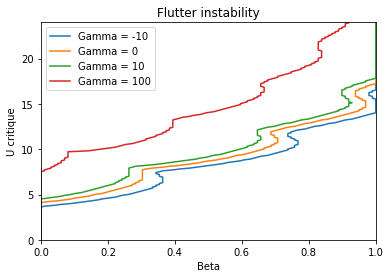

In [8]:
mpl.xlim((0,1))
mpl.ylim((0,24))
mpl.plot(b_critique[0,:],u_array,label='Gamma = -10')
mpl.plot(b_critique[1,:],u_array,label='Gamma = 0')
mpl.plot(b_critique[2,:],u_array,label='Gamma = 10')
mpl.plot(b_critique[3,:],u_array,label='Gamma = 100')
mpl.legend()
mpl.xlabel("Beta")
mpl.ylabel("U critique")
mpl.title("Flutter instability")
mpl.savefig('flutter.jpg')
mpl.show()